## Import and Load Relevant Packages and Utilities

In [1]:
import os
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from utils import filter_data, interpolate_missing_data, perform_dfa, perform_dfa_for_plotting, perform_nolds_dfa

## Windowed DFA analysis and Plotting Helper Function - for initial visual inspection

In [2]:
# Perform windowed DFA analysis and plot
def windowed_dfa_analysis(directory, filename, window_size, columns, min_window_size=4, plot=False):
    
    # Create the file path
    file_path = os.path.join(directory, filename)

    #Check if the file exists
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist.")
        return

    # Load the data
    data = pd.read_csv(file_path)

    # zscore normalize the data
    data = (data - data.mean()) / data.std()

    # Ensure metrics is a list and check if columns exist
    if isinstance(columns, list) and all(column in data.columns for column in columns):
        dfa_data = data[columns]
    else:
        print(f"Columns {columns} are not all present in the data {data.columns.tolist()}")
        return

    num_windows = len(dfa_data) // window_size

    results = []
    for window_index in range(num_windows):
        dfa_window_data = dfa_data.iloc[window_index*window_size:(window_index+1)*window_size]

        dfa_results = perform_dfa_for_plotting(dfa_window_data, min_window_size)

        result_row = {
            'filename': filename,
            'window_index': window_index
        }

        for column, result in dfa_results.items():
            result_row[f'{column}_alpha'] = result['alpha']

        results.append(result_row)

        if plot:
            # Plot the time series and DFA results
            plt.figure(figsize=(12, 8))
            
            # Plot time series
            plt.subplot(3, 1, 1)
            for col in dfa_window_data.columns:
                plt.plot(dfa_window_data[col], label=col)
            plt.title(f'Time Series for Window {window_index + 1}')
            plt.legend()

            # Plot RMS of fluctuations vs. window size and show the slope (alpha) and fit line
            plt.subplot(3, 1, 2)
            for col, result in dfa_results.items():
                scales = result['scales']
                flucts = result['flucts']
                fit_line = result['fit_line']
                plt.loglog(scales, flucts, 'o-', label=f'{col} (alpha = {result["alpha"]:.2f})')
                plt.loglog(scales, np.exp(fit_line), '--', label=f'Fit line ({col})')
            plt.title('RMS of Fluctuations vs. Window Size')
            plt.xlabel('Window size (samples)')
            plt.ylabel('RMS of fluctuations')
            plt.legend()

            plt.tight_layout()
            plt.show()

    # Return the results
    return results

## Run Windowed DFA on a file and Plot data and DFA analysis for visual inspection

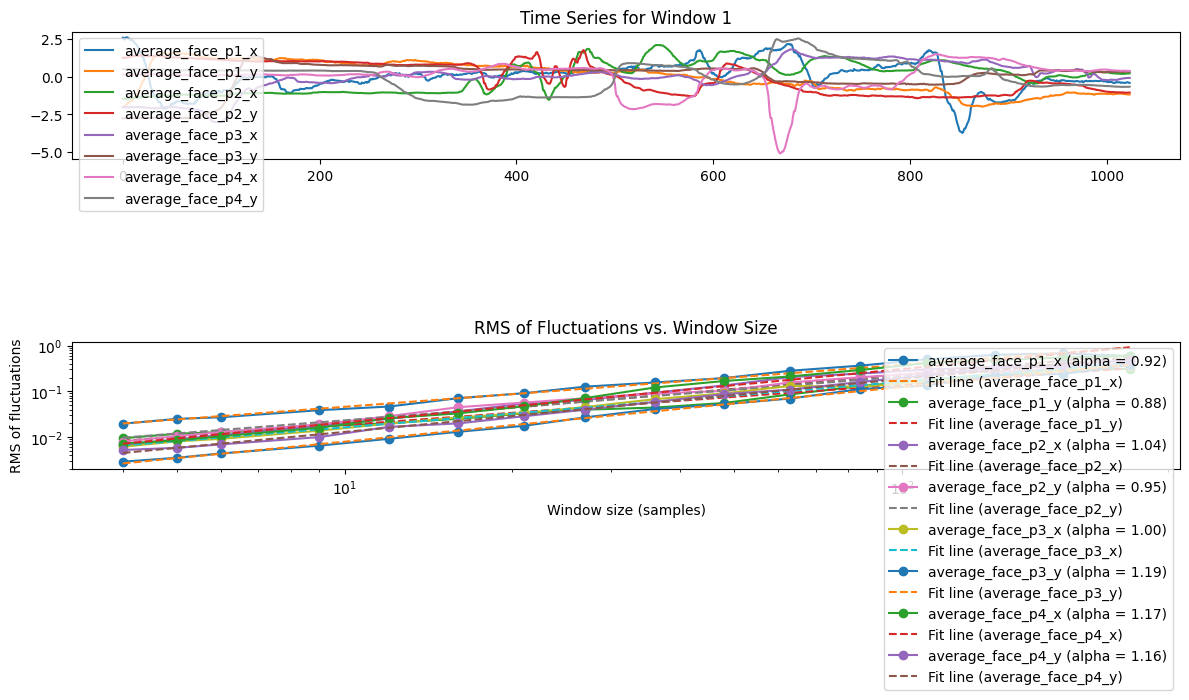

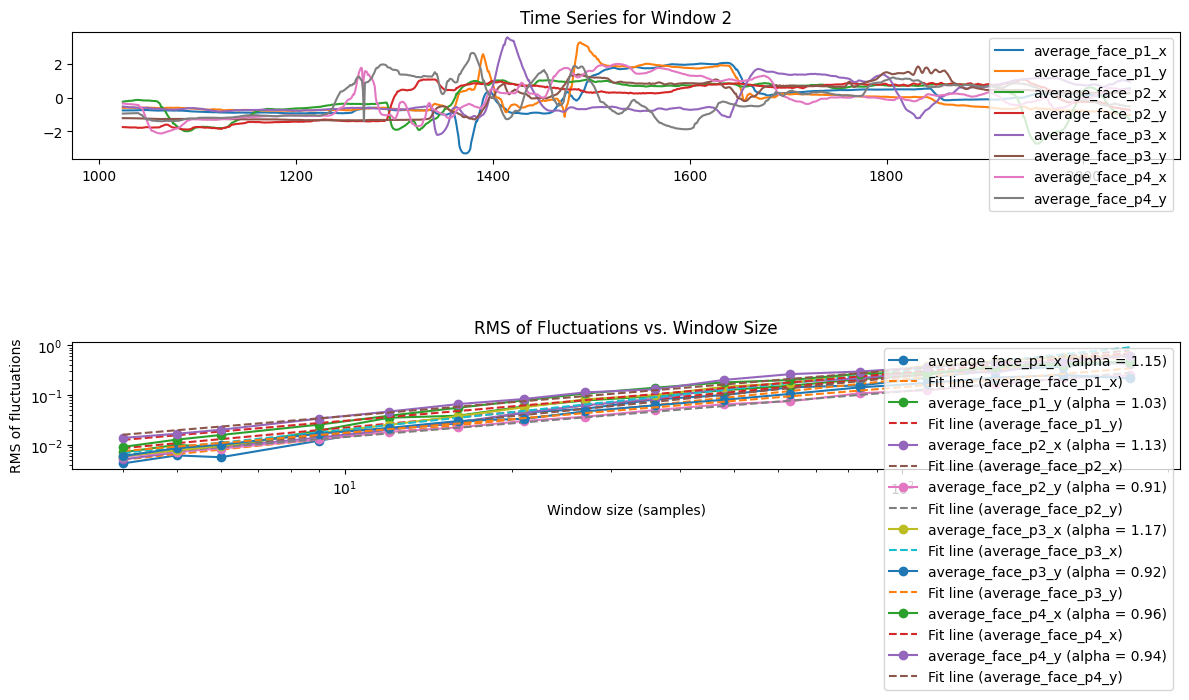

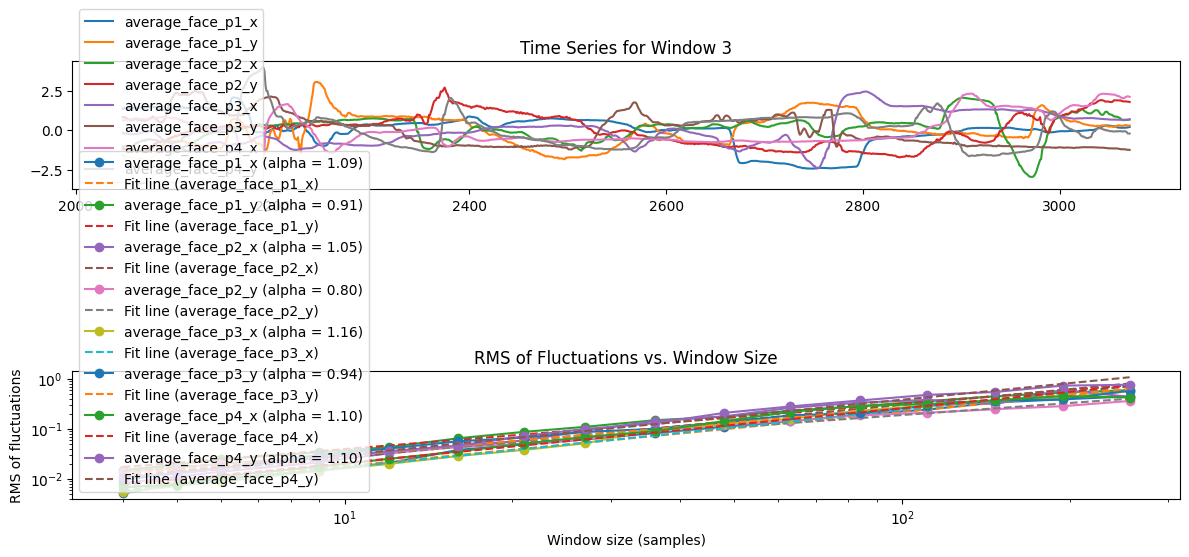

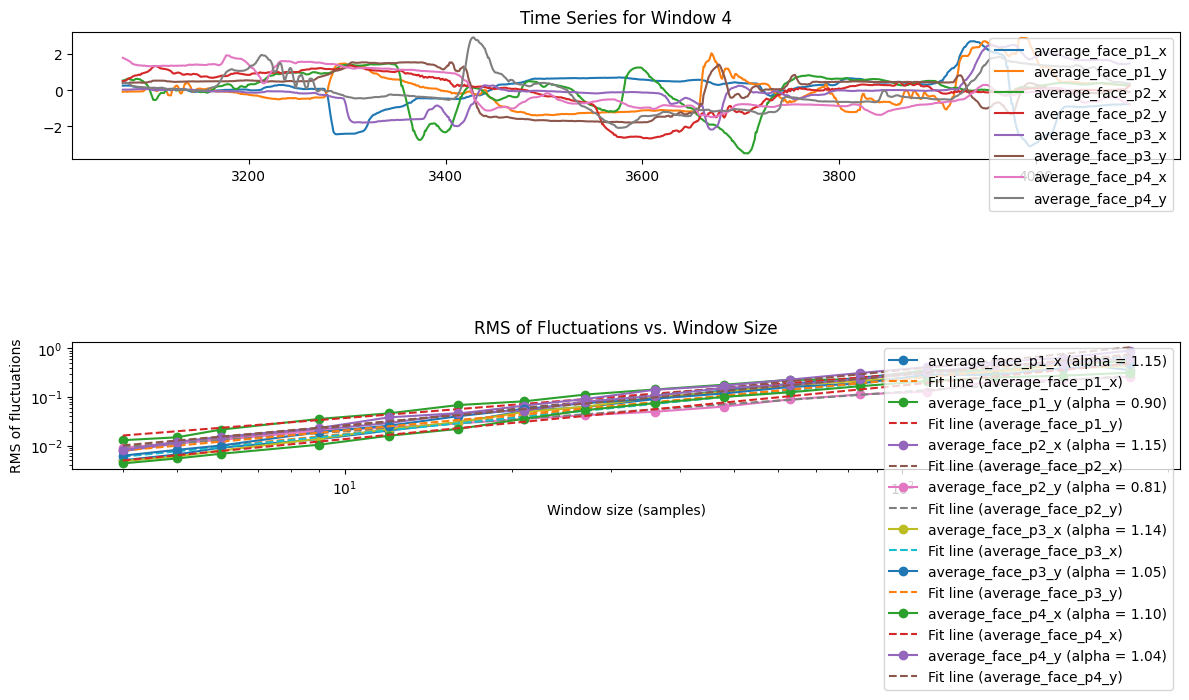

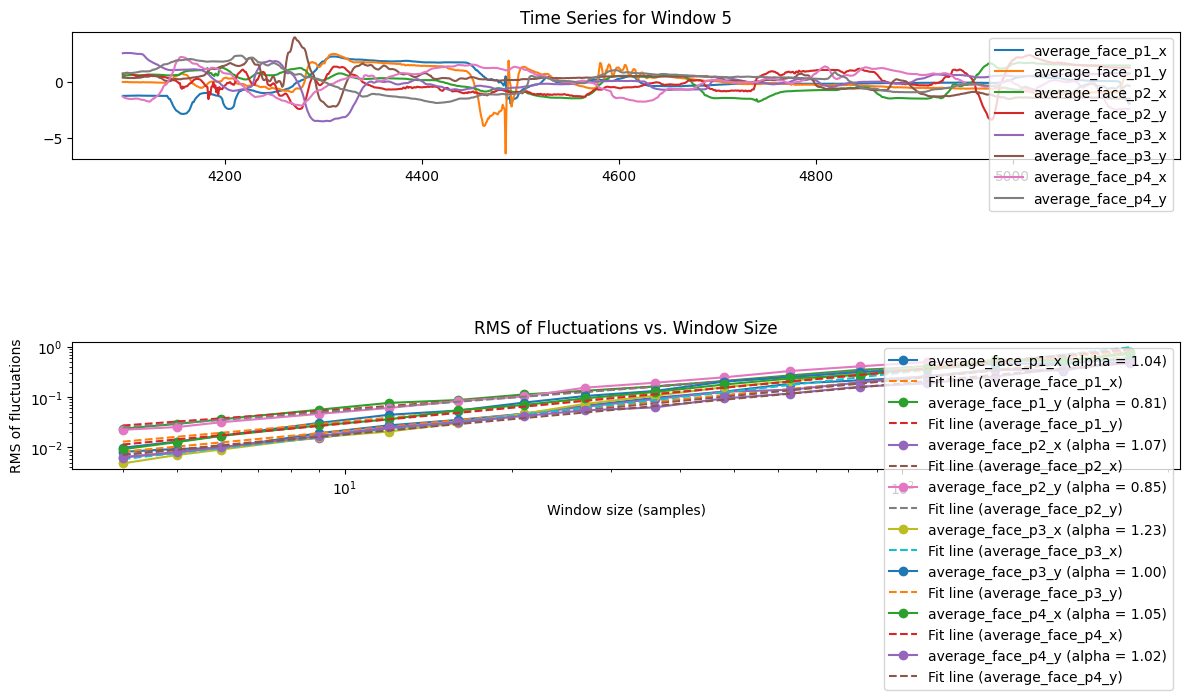

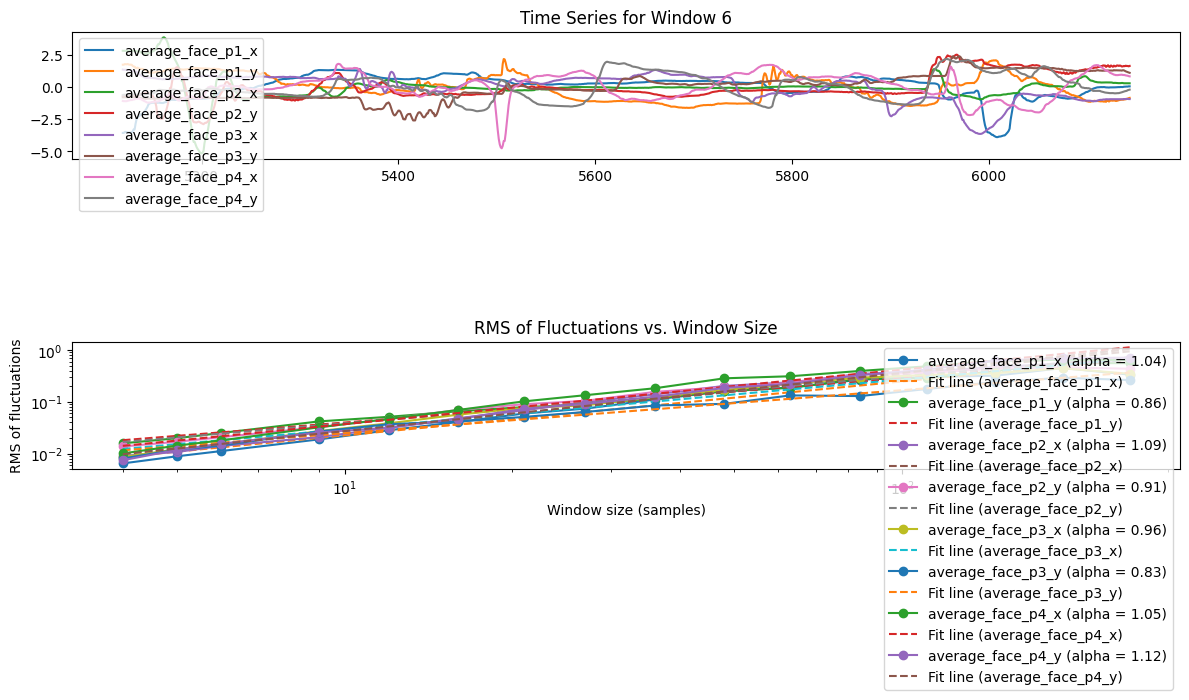

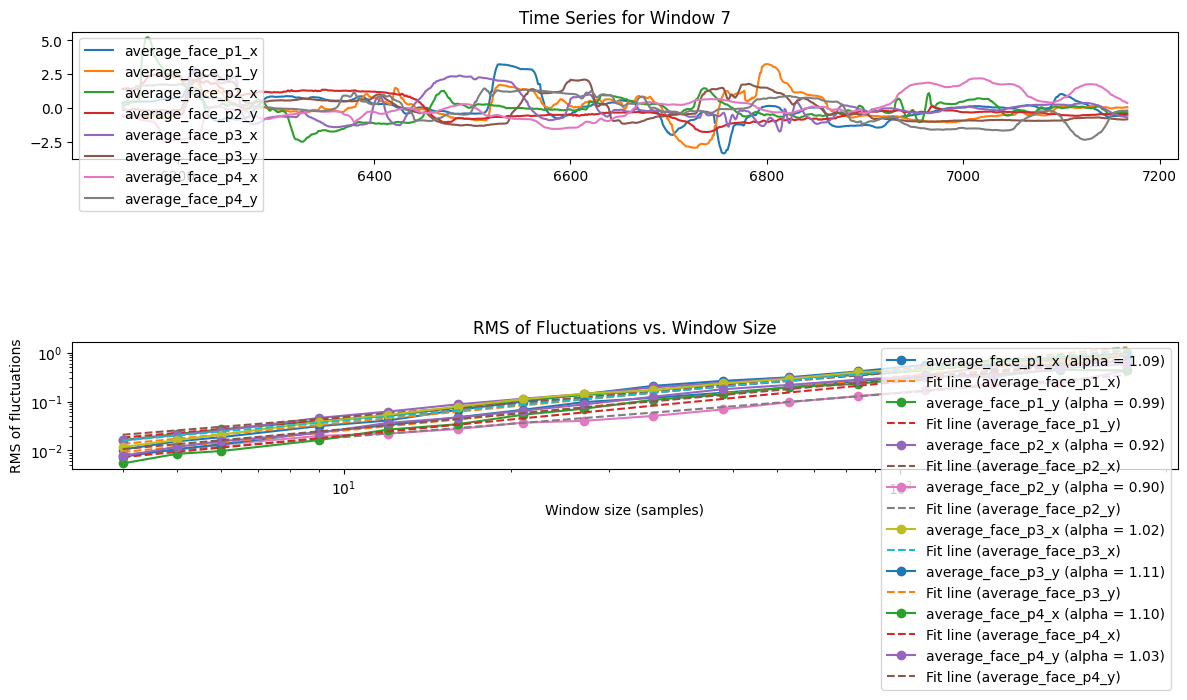

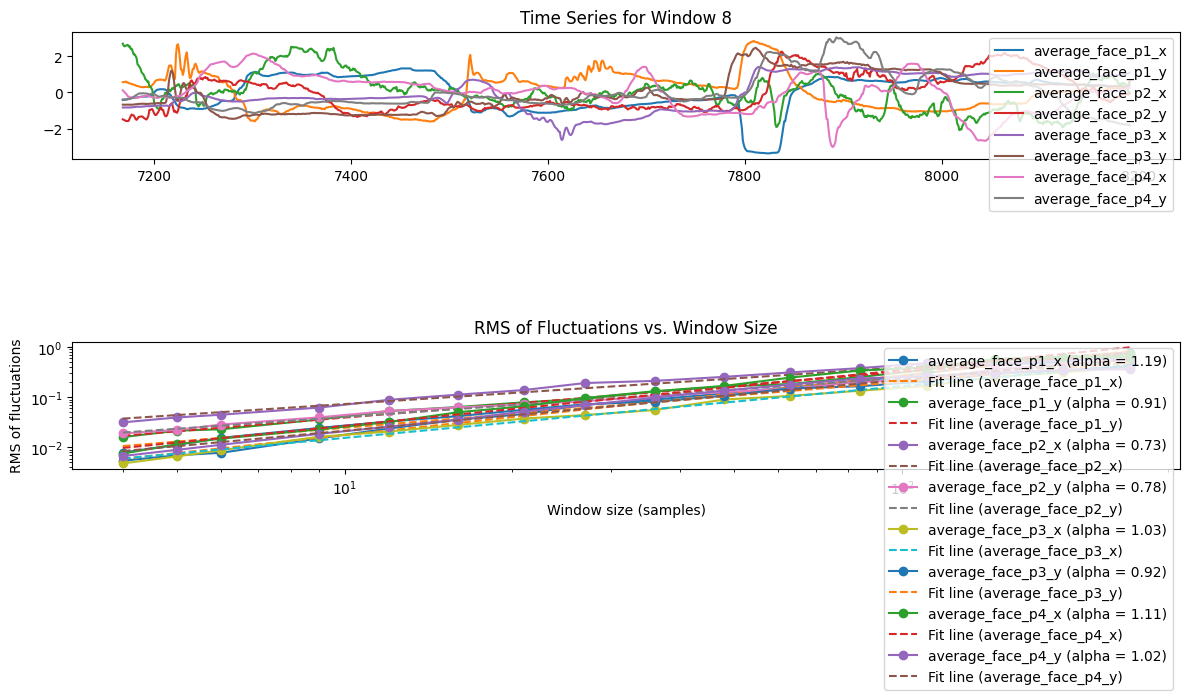

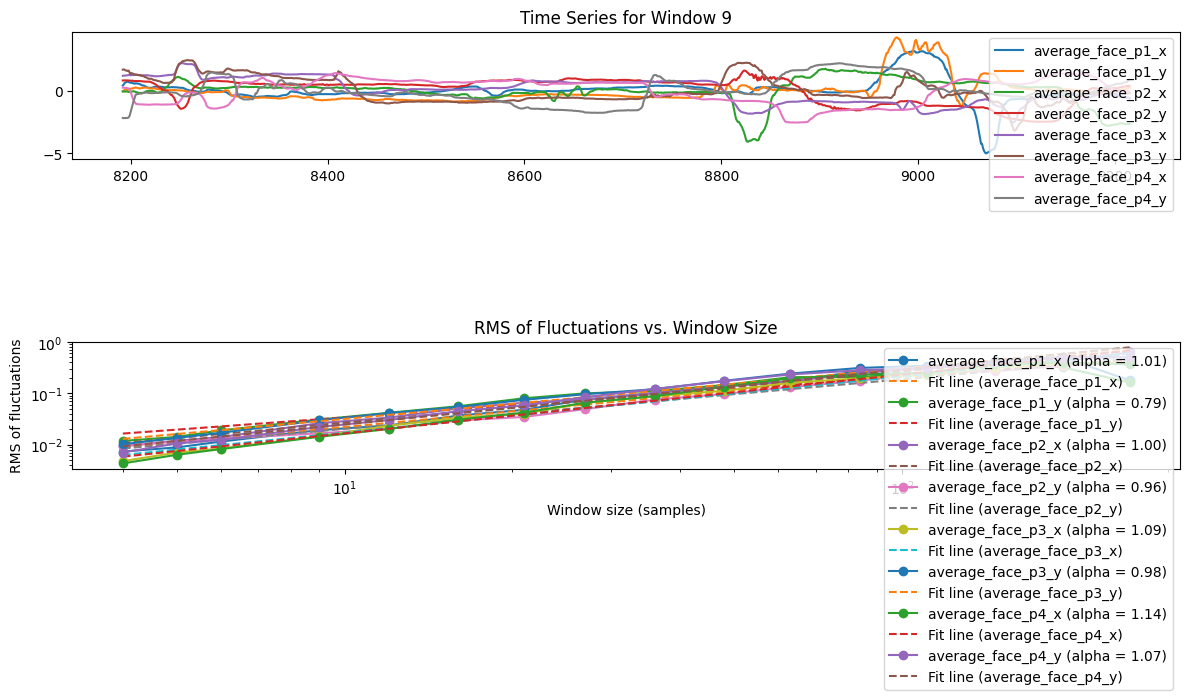

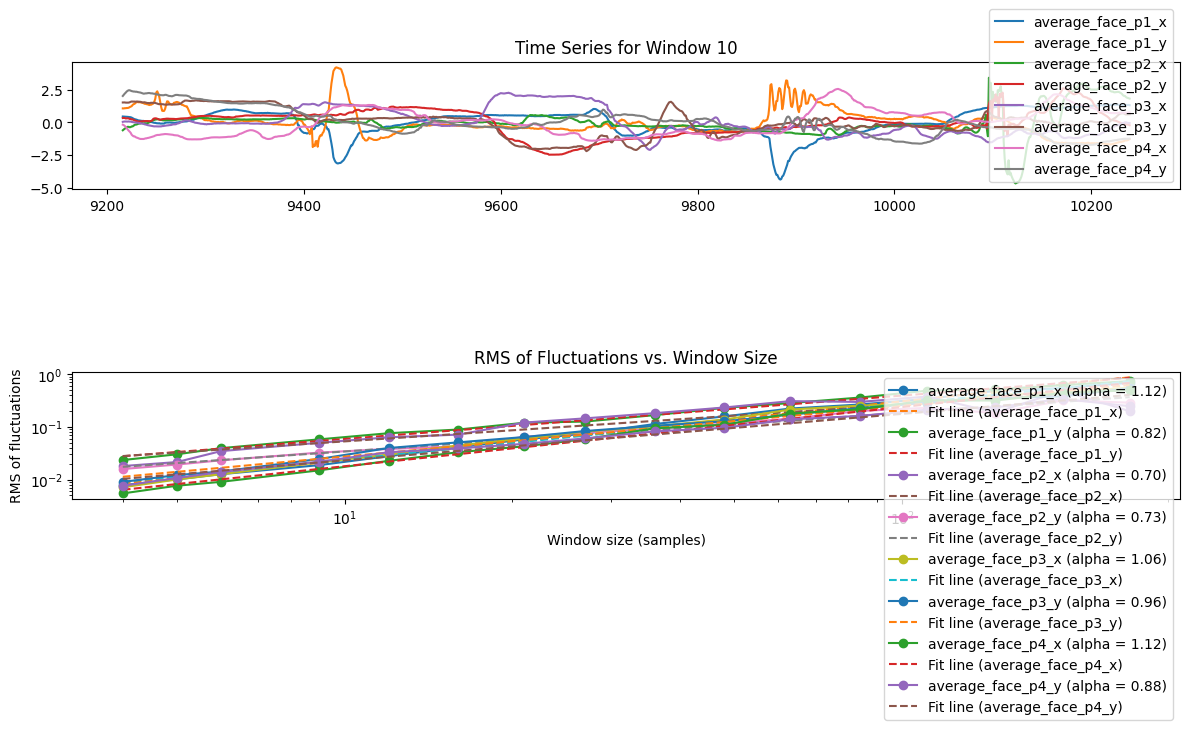

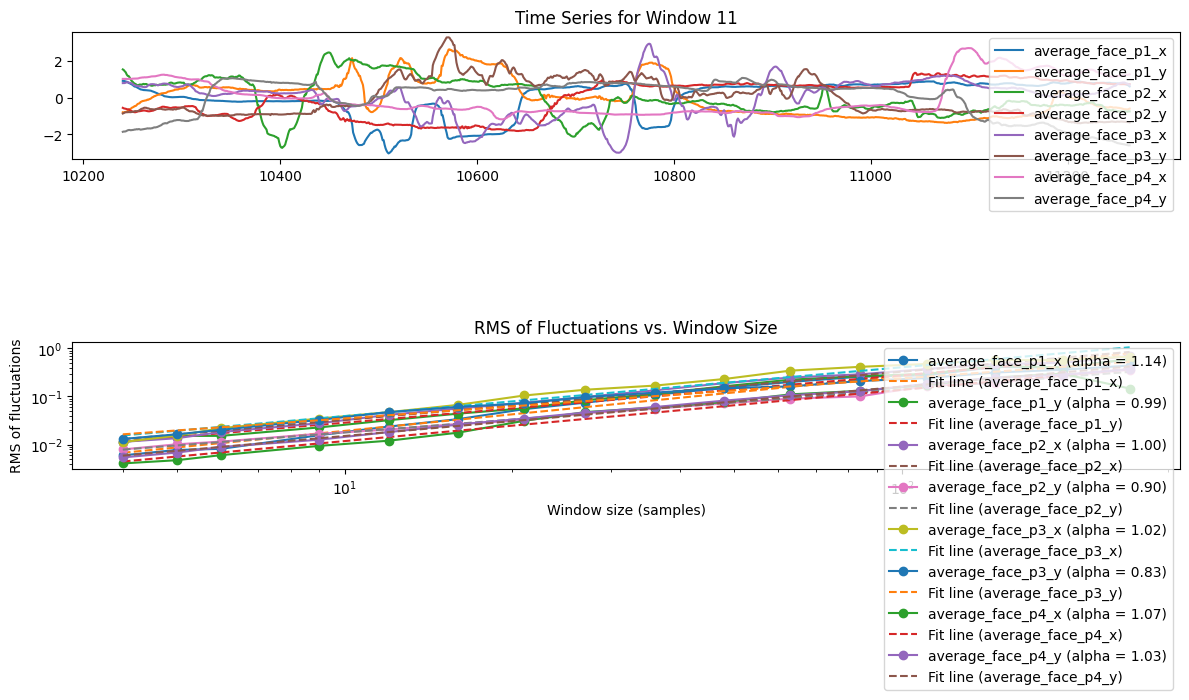

In [4]:
# Run the windowed DFA analysis and plot for a randomly selected file
directory = "../../Data/Honours2024/LostAtSea/processed_csvs"  # Update this path to the correct directory

 # Update this to the desired participant ID
part_number = 402 

# Construct the filename and file path
filename = f"{part_number}_GRP.csv"

# Set the window size
window_size = 1024

columns = [
        'average_face_p1_x', 'average_face_p1_y',
        'average_face_p2_x', 'average_face_p2_y',
        'average_face_p3_x', 'average_face_p3_y',
        'average_face_p4_x', 'average_face_p4_y'
    ]

_ = windowed_dfa_analysis(directory, filename, window_size, columns, plot=True)

## Run a Windowed DFA analysis on all of the Data

In [2]:
# Set the directory path for the data
directory = "../../Data/Honours2024/LostAtSea/processed_csvs"  # Update this path to the correct directory

# Set the frame rate and window size in seconds
window_size = 1024
overlap = 0.5  # 50% overlap
step_size = int(window_size * (1 - overlap))  # Step size for windows

# Initialize a list to store results for the CSV
csv_results = []

# Get the number of CSV files in the directory
num_files = len([filename for filename in os.listdir(directory) if filename.endswith('.csv')])
index = 0

# Set the analysis parameters
analysis_parameters = f"_windowSize{window_size}"

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Process the files
        file_path = os.path.join(directory, filename)

        # Load the CSV file into a DataFrame
        data = pd.read_csv(file_path)

        # Update the progress
        index += 1

        # Get group number from filename
        group_number = int(filename.split('_')[0])

        # Get condition "group" = GRP or individual = IND from file name (before .csv)
        condition = filename.split('_')[1]

        # Select only the relevant columns
        columns = [
            'average_face_p1_x', 'average_face_p1_y',
            'average_face_p2_x', 'average_face_p2_y', 
            'average_face_p3_x', 'average_face_p3_y', 
            'average_face_p4_x', 'average_face_p4_y'
        ]

        # Only use the specified columns
        data = data[columns]

        # Initialize result_row to store the average DFA metrics for this file
        result_row = {
            'filename': filename,
            'group_number': group_number,
            'condition': condition,
            'num_windows': 0
        }

        # List to store metrics for all windows
        all_results = []

        # Skipped windows index
        skipped_windows_index = 0

        # Iterate over the data in windows with 50% overlap
        for start in range(0, len(data) - window_size + 1, step_size):
            # Get the window of data
            window = data[start:start + window_size]

            # Check if there are more than 90 consecutive missing values in any column
            if any(window.apply(lambda col: col.isnull().astype(int).groupby(col.notnull().astype(int).cumsum()).cumsum().max() > 90)):
                print(f"Skipping window starting at {start} as it contains more than 90 consecutive missing values")
                skipped_windows_index += 1
                continue

            # Interpolate missing data
            window = interpolate_missing_data(window)

            # Filter the data
            window = filter_data(window)

            # Z-score normalization
            window = (window - window.mean()) / window.std()

            # Perform DFA on the window
            results = perform_dfa(window)

            if isinstance(results, dict):
                results = pd.Series(results)

            all_results.append(results)
            result_row['num_windows'] += 1

        # If there are valid windows, average the metrics over all windows
        if all_results:
            all_results_df = pd.DataFrame(all_results)
            avg_results = all_results_df.mean().to_dict()
            result_row.update(avg_results)
            result_row['skipped_windows'] = skipped_windows_index

        # Append the results to the list
        csv_results.append(result_row)

        # Update the progress
        clear_output(wait=True)
        print(f'Processed {index}/{num_files} files')

# Save results to CSV
csv_df = pd.DataFrame(csv_results)
output_path = f'analysis/dfa/lostAtSea_dfaAnalysis{analysis_parameters}.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
csv_df.to_csv(output_path, index=False)

print(f'Results saved to {output_path}')


Processed 69/69 files
Results saved to analysis/dfa/lostAtSea_dfaAnalysis_windowSize1024.csv


## Create Box plots for a Specified RQA Analysis and set of RQA Metrics

/var/folders/_n/5wxln6_12gb153kv9xc_63mm0000gp/T/ipykernel_11199/824554454.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='value', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})


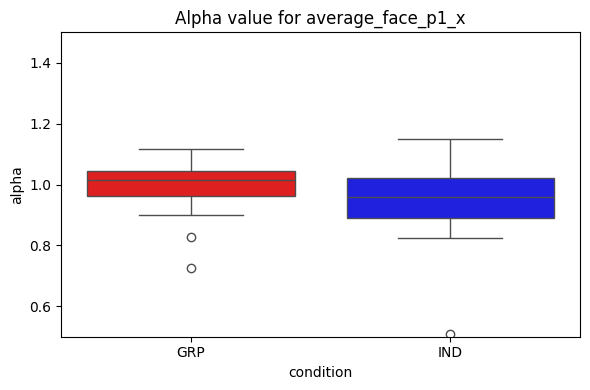

/var/folders/_n/5wxln6_12gb153kv9xc_63mm0000gp/T/ipykernel_11199/824554454.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='value', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})


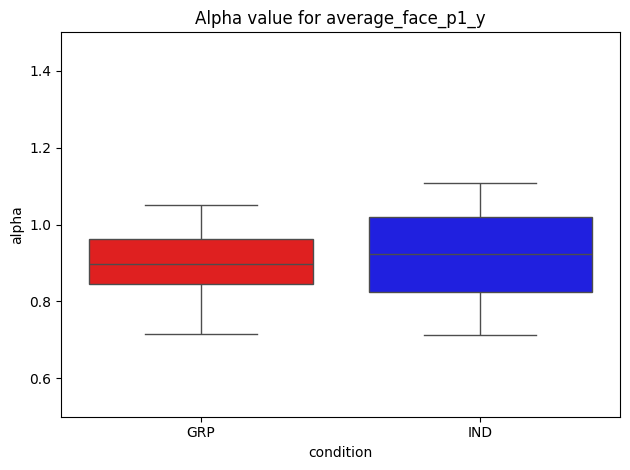

/var/folders/_n/5wxln6_12gb153kv9xc_63mm0000gp/T/ipykernel_11199/824554454.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='value', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})


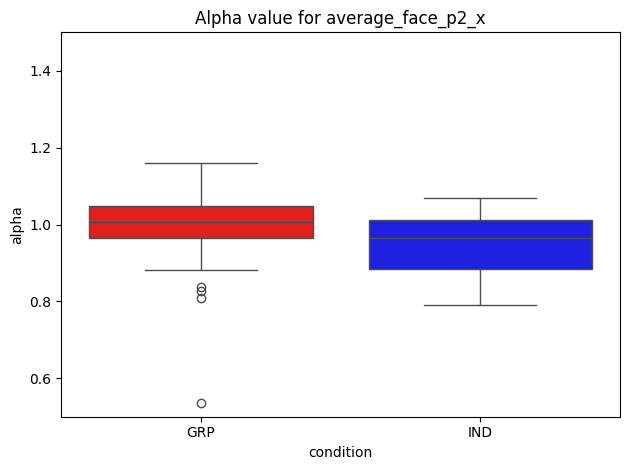

/var/folders/_n/5wxln6_12gb153kv9xc_63mm0000gp/T/ipykernel_11199/824554454.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='value', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})


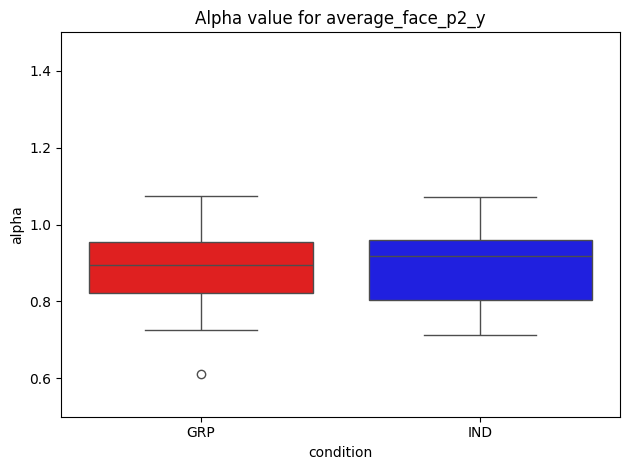

/var/folders/_n/5wxln6_12gb153kv9xc_63mm0000gp/T/ipykernel_11199/824554454.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='value', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})


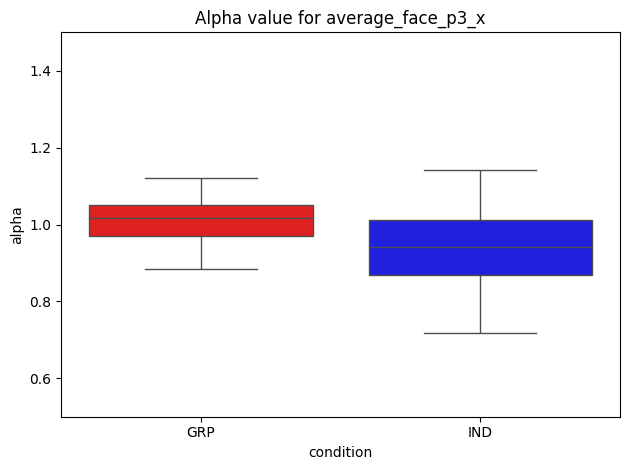

/var/folders/_n/5wxln6_12gb153kv9xc_63mm0000gp/T/ipykernel_11199/824554454.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='value', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})


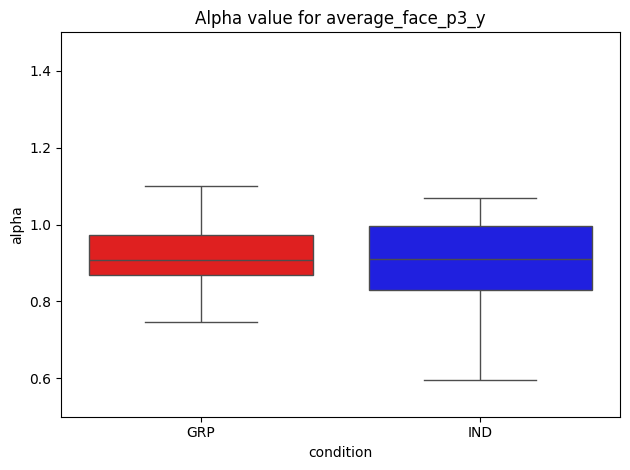

/var/folders/_n/5wxln6_12gb153kv9xc_63mm0000gp/T/ipykernel_11199/824554454.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='value', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})


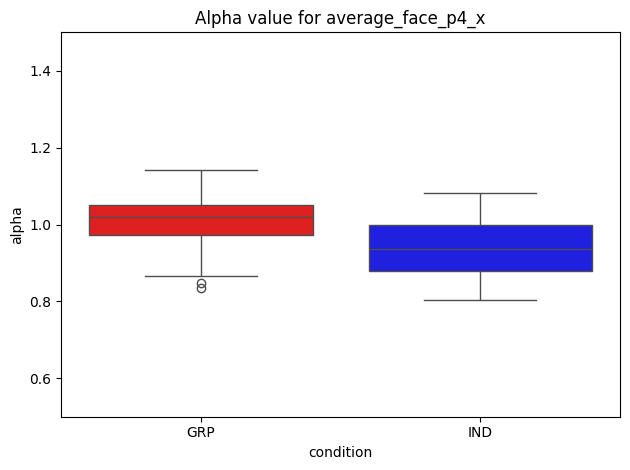

/var/folders/_n/5wxln6_12gb153kv9xc_63mm0000gp/T/ipykernel_11199/824554454.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='value', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})


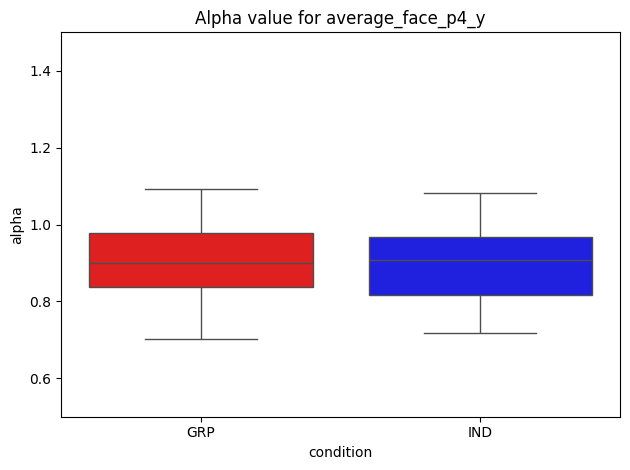

In [8]:
# Set the window size
window_size = 1024

# Set the analysis parameters
analysis_parameters = f"_windowSize{window_size}"

# Load the analysis results from the CSV file
csv_file = f'analysis/dfa/lostAtSea_dfaAnalysis{analysis_parameters}.csv'  # Update this path to the correct file
data = pd.read_csv(csv_file)

# Ensure the 'condition' column has correct values
data['condition'] = data['condition'].str.replace('.csv', '')

#------------------------------------------------------------------------------------
# REMOVE STRANGE DATA !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# There is a GRP_2 condition that should be GRP or removed. Remove it for consistency
data = data[data['condition'] != 'GRP_2']
data = data[data['group_number'] != 408]
#------------------------------------------------------------------------------------

# Initialize the plot
plt.figure(figsize=(6, 4))

# Plot data for each column's alpha value
for column in ['average_face_p1_x', 'average_face_p1_y', 'average_face_p2_x', 'average_face_p2_y', 'average_face_p3_x', 'average_face_p3_y', 'average_face_p4_x', 'average_face_p4_y']:
    plot_data = data[['condition', column]].copy()
    plot_data.columns = ['condition', 'value']

    sns.boxplot(x='condition', y='value', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})
    plt.title(f'Alpha value for {column}')
    plt.ylabel('alpha')
    plt.ylim([.5, 1.5])
    
    # Adjust layout and show the plot for each column
    plt.tight_layout()
    plt.show()
